# Análise de Integração ao Sistema Nacional de Trânsito (SNT)

Este notebook apresenta uma análise detalhada dos fatores que influenciam a integração dos municípios ao Sistema Nacional de Trânsito (SNT).

## 1. Importação das Bibliotecas e Carregamento dos Dados

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Carregar os dados
df = pd.read_excel('/home/fause/ML-Transportes/Dados/analiseestatistica_indicadores2.xlsx') 
print("Dimensões do dataset:", df.shape)
df.head()


Dimensões do dataset: (5570, 27)


,UF,Estado,codigo_ibge,Integrado ao SNT,Sinistros,Z-score Sinistros,População,Z-score população,Soma da Arrecadação 2018-2023,Z-score Arrecadação,...,IDHM,Z-score IDHM,Taxa de Admissão em Empregos,300,Taxa de Óbitos/100 mil habitantes,Z-score Tx óbito/100 mil hab,% de Óbitos/Sinistros,Z-score Óbitos/Sinistros,area_km2,km_rodovias_federais
0,RO,Rondônia,1100015,Não,1102,-0.006384,21494,-0.072467,3.291565e+09,-0.076026,...,0.641,-0.217690,0.509897,-0.094854,162.836140,1.001660,3.176044,-0.600753,7067.127,0.000000
1,RO,Rondônia,1100023,Sim,5622,0.453483,96833,0.292338,1.718637e+10,0.164665,...,0.702,0.567787,0.505000,-0.172360,171.429162,1.122970,2.952686,-0.607705,4426.143,77.806543
2,RO,Rondônia,1100031,Não,185,-0.099680,5351,-0.150634,1.672614e+09,-0.104070,...,0.650,-0.101800,0.515403,-0.007693,224.257148,1.868761,6.486486,-0.497720,1314.352,0.000000
3,RO,Rondônia,1100049,Sim,5957,0.487566,86887,0.244178,1.279220e+10,0.088548,...,0.718,0.773814,0.511808,-0.064596,159.977902,0.961309,2.333389,-0.626980,3793.000,51.712641
4,RO,Rondônia,1100056,Não,732,-0.044028,15890,-0.099602,3.614702e+09,-0.070429,...,0.692,0.439020,0.500262,-0.247362,195.091252,1.457016,4.234973,-0.567796,2783.297,29.154767


## 2. Análise Exploratória dos Dados

In [40]:
# Informações gerais do dataframe
print("Informações do DataFrame:")
print(df.info())

print("\nEstatísticas descritivas:")
print(df.describe())

print("\nValores nulos por coluna:")
print(df.isnull().sum())

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   UF                                 5570 non-null   object 
 1   Estado                             5570 non-null   object 
 2   codigo_ibge                        5570 non-null   int64  
 3   Integrado ao SNT                   5570 non-null   object 
 4   Sinistros                          5570 non-null   int64  
 5   Z-score Sinistros                  5570 non-null   float64
 6   População                          5570 non-null   int64  
 7   Z-score população                  5570 non-null   float64
 8   Soma da Arrecadação 2018-2023      5570 non-null   float64
 9   Z-score Arrecadação                5570 non-null   float64
 10  PIB                                5570 non-null   float64
 11  Z-score PIB                   

In [55]:
import pandas as pd

# Função de classificação
def classificar_pib_per_capita(valor):
    if valor >= 100_000:
        return "Altíssimo desenvolvimento"
    elif valor >= 60_000:
        return "Alto desenvolvimento"
    elif valor >= 30_000:
        return "Desenvolvimento intermediário"
    elif valor >= 15_000:
        return "Baixo desenvolvimento"
    else:
        return "Muito baixo desenvolvimento"

# Supondo que seu DataFrame se chame df e tenha a coluna 'pib_per_capita'
df['classe_pib_per_capita'] = df['PIB per capita'].apply(classificar_pib_per_capita)

# Contagem de municípios por classe
contagem_por_classe = df['classe_pib_per_capita'].value_counts().sort_index()

# Exibir o resultado
print("Quantidade de municípios por classificação de PIB per capita:\n")
print(contagem_por_classe)


Quantidade de municípios por classificação de PIB per capita:

classe_pib_per_capita
Alto desenvolvimento               31
Altíssimo desenvolvimento          16
Baixo desenvolvimento            1080
Desenvolvimento intermediário     185
Muito baixo desenvolvimento      4166
Name: count, dtype: int64


## 3. Tratamento dos Dados

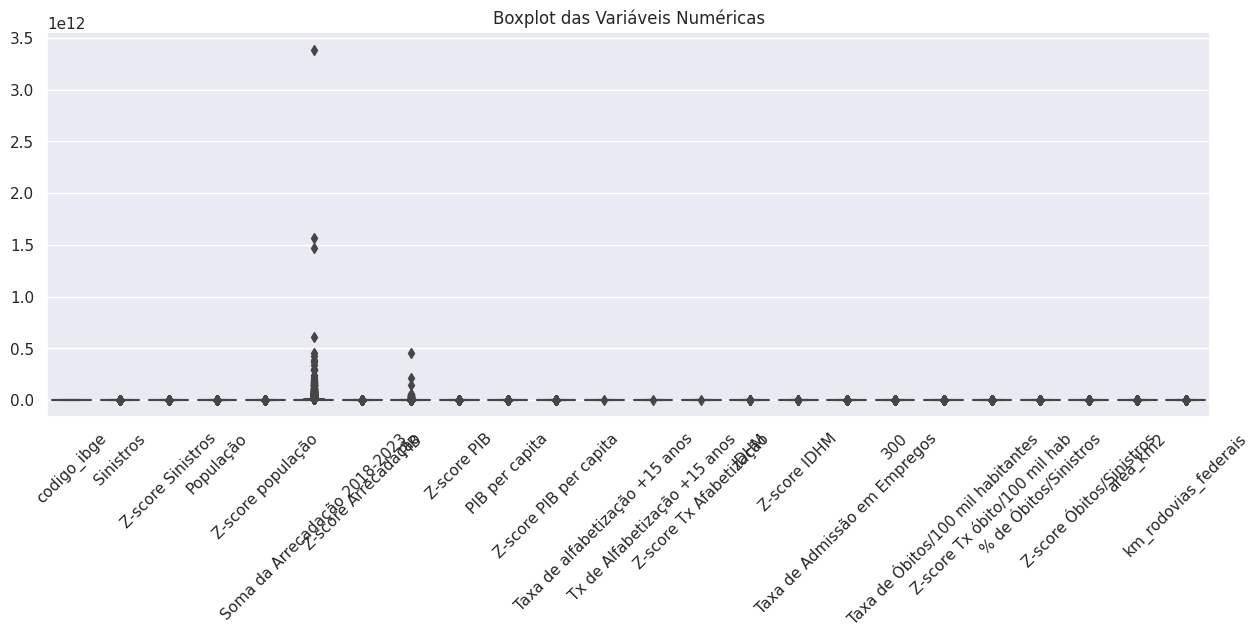

In [41]:
# Tratamento de valores nulos
#df['km_rodovias_federais'] = df['km_rodovias_federais'].fillna(0)
#df['area_km2'] = df['area_km2'].fillna(df['area_km2'].median())
df.dropna(inplace=True)


# Visualização de outliers
plt.figure(figsize=(15, 5))
sns.boxplot(data=df.select_dtypes(include='number'))
plt.xticks(rotation=45)
plt.title('Boxplot das Variáveis Numéricas')
plt.show()

# Codificação de variáveis categóricas
df = pd.get_dummies(df, columns=['UF', 'Estado'], drop_first=True)

## 4. Preparação do Modelo

In [42]:
# Definição das features
features = ['Sinistros','PIB per capita', 'Tx de Alfabetização +15 anos', 
           'Taxa de Admissão em Empregos', 'IDHM', 
           'Taxa de Óbitos/100 mil habitantes', '% de Óbitos/Sinistros',
           'area_km2', 'km_rodovias_federais']

features2 = ['Sinistros','PIB per capita', 'Tx de Alfabetização +15 anos', 
           'Taxa de Admissão em Empregos', 'IDHM',  '% de Óbitos/Sinistros',
           'area_km2', 'km_rodovias_federais']

X = df[features]
y = df['Integrado ao SNT']
y = y.map({'Sim': 1, 'Não': 0})

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processamento
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

## 5. Treinamento e Avaliação do Modelo Random Forest

In [43]:
# Treinamento do modelo
rf_model = RandomForestClassifier(n_estimators=500, class_weight=None, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predição e avaliação
y_pred = rf_model.predict(X_test_scaled)
print("\nRelatório de Classificação após SMOTE:\n")
print(classification_report(y_test, y_pred))


Relatório de Classificação após SMOTE:

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       718
           1       0.80      0.77      0.78       378

    accuracy                           0.85      1096
   macro avg       0.84      0.83      0.83      1096
weighted avg       0.85      0.85      0.85      1096



## 6. Análise de Importância das Features

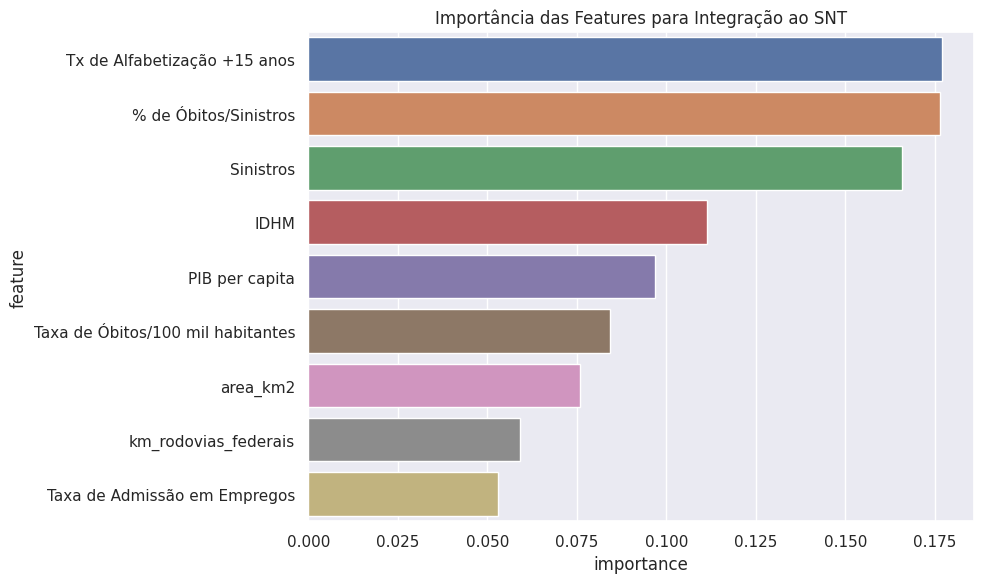


Importância das Features (%):

                             feature  importance
2       Tx de Alfabetização +15 anos       17.71
6              % de Óbitos/Sinistros       17.65
0                          Sinistros       16.59
4                               IDHM       11.13
1                     PIB per capita        9.69
5  Taxa de Óbitos/100 mil habitantes        8.43
7                           area_km2        7.60
8               km_rodovias_federais        5.90
3       Taxa de Admissão em Empregos        5.30


In [44]:
# Importância das features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features para Integração ao SNT')
plt.tight_layout()
plt.show()

print("\nImportância das Features (%):\n")
print(feature_importance.assign(importance=lambda x: x['importance']*100).round(2))

## 7. Matriz de Correlação

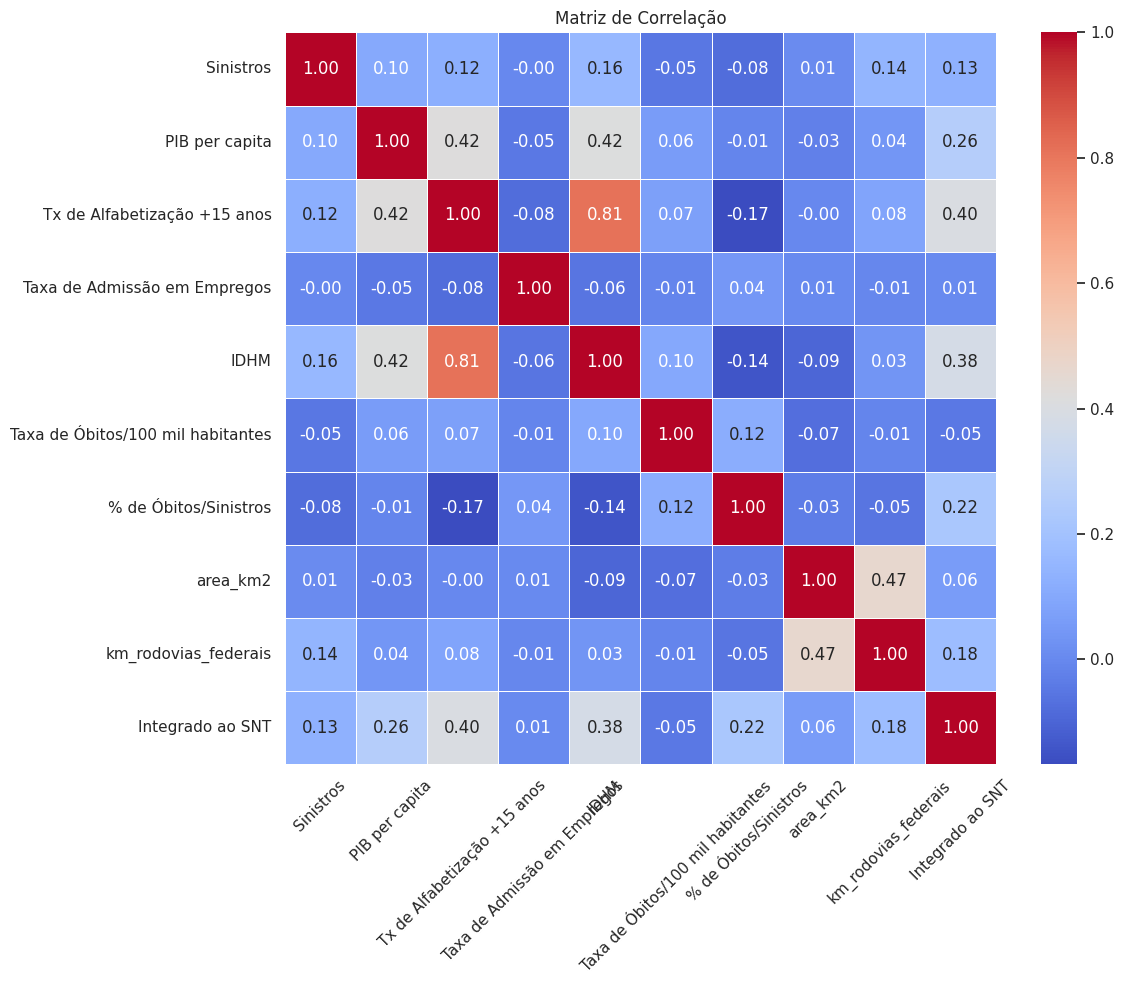

In [45]:
# Matriz de correlação
plt.figure(figsize=(12, 10))
correlation_matrix = df[features + ['Integrado ao SNT']].copy()
correlation_matrix['Integrado ao SNT'] = y

corr = correlation_matrix.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Matriz de Confusão

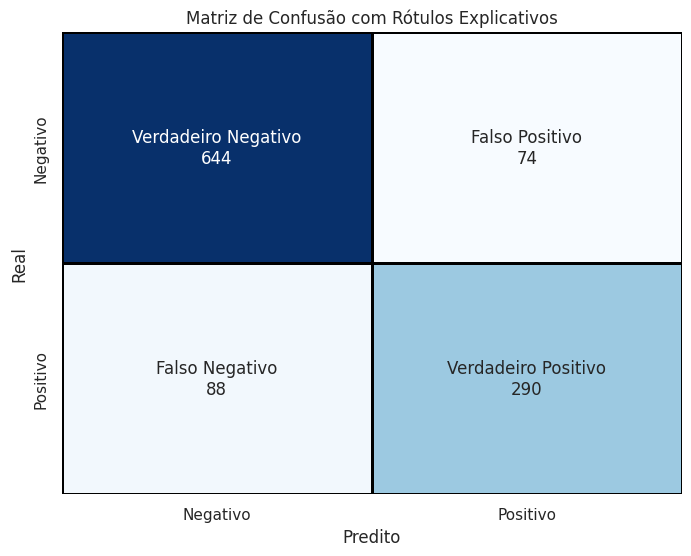

In [46]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

labels = [
    ["Verdadeiro Negativo", "Falso Positivo"],
    ["Falso Negativo", "Verdadeiro Positivo"]
]

annot = [[f"{label}\n{cm[i][j]}" for j, label in enumerate(row)] for i, row in enumerate(labels)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False, linewidths=1, linecolor='black')
plt.title('Matriz de Confusão com Rótulos Explicativos')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.xticks(ticks=[0.5, 1.5], labels=['Negativo', 'Positivo'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negativo', 'Positivo'])
plt.show()

## 9. Comparação com Outros Modelos

In [47]:
# Regressão Logística
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test_scaled)
print("Regressão Logística:")
print(classification_report(y_test, y_pred))


Regressão Logística:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       718
           1       0.70      0.69      0.69       378

    accuracy                           0.79      1096
   macro avg       0.77      0.77      0.77      1096
weighted avg       0.79      0.79      0.79      1096



In [48]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test_scaled)
print("\nNaive Bayes:")
print(classification_report(y_test, y_pred))


Naive Bayes:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       718
           1       0.81      0.50      0.62       378

    accuracy                           0.79      1096
   macro avg       0.80      0.72      0.74      1096
weighted avg       0.79      0.79      0.77      1096



In [49]:
# XGBoost
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test_scaled)
print("\nXGBoost:")
print(classification_report(y_test, y_pred))


XGBoost:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       718
           1       0.80      0.81      0.80       378

    accuracy                           0.86      1096
   macro avg       0.85      0.85      0.85      1096
weighted avg       0.87      0.86      0.87      1096



## 10. Análise para Municípios com População > 20.000 habitantes


Relatório de Classificação — População > 20 mil:
              precision    recall  f1-score   support

         Não       0.66      0.70      0.68       124
         Sim       0.82      0.80      0.81       216

    accuracy                           0.76       340
   macro avg       0.74      0.75      0.75       340
weighted avg       0.77      0.76      0.76       340



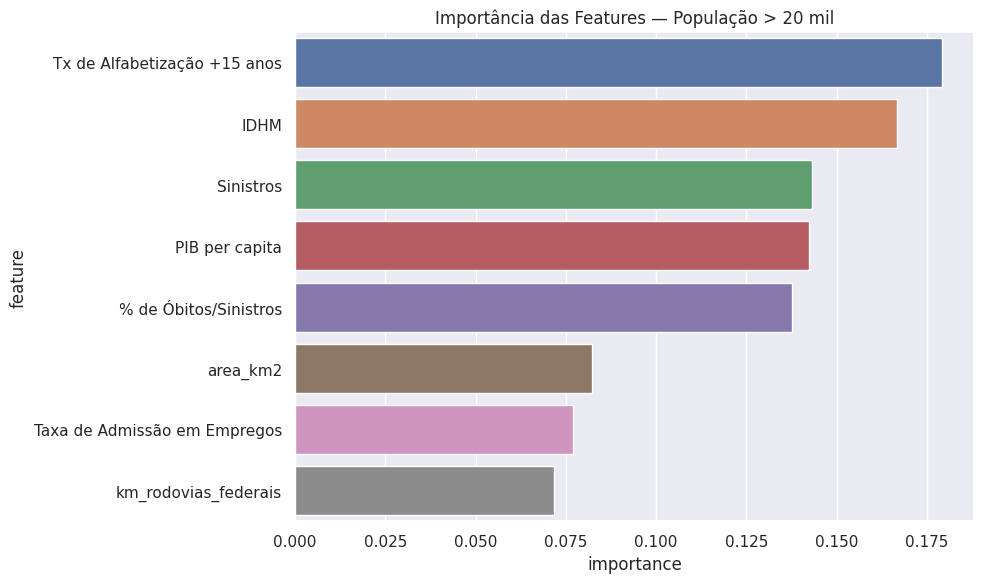

In [51]:
# Filtrar municípios
df_acima_100k = df[df['População'] > 20000]

# Preparação dos dados
X = df_acima_100k[features2]
y = df_acima_100k['Integrado ao SNT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processamento
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Modelo
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Avaliação
y_pred = rf_model.predict(X_test_scaled)
print("\nRelatório de Classificação — População > 20 mil:")
print(classification_report(y_test, y_pred))

# Importância das features
feature_importance = pd.DataFrame({
    'feature': features2,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features — População > 20 mil')
plt.tight_layout()
plt.show()

## 11. Análise para Municípios com População <> 20.000 habitantes


Relatório de Classificação — População < 20 mil:
              precision    recall  f1-score   support

         Não       0.92      0.91      0.92       622
         Sim       0.62      0.65      0.63       134

    accuracy                           0.87       756
   macro avg       0.77      0.78      0.78       756
weighted avg       0.87      0.87      0.87       756



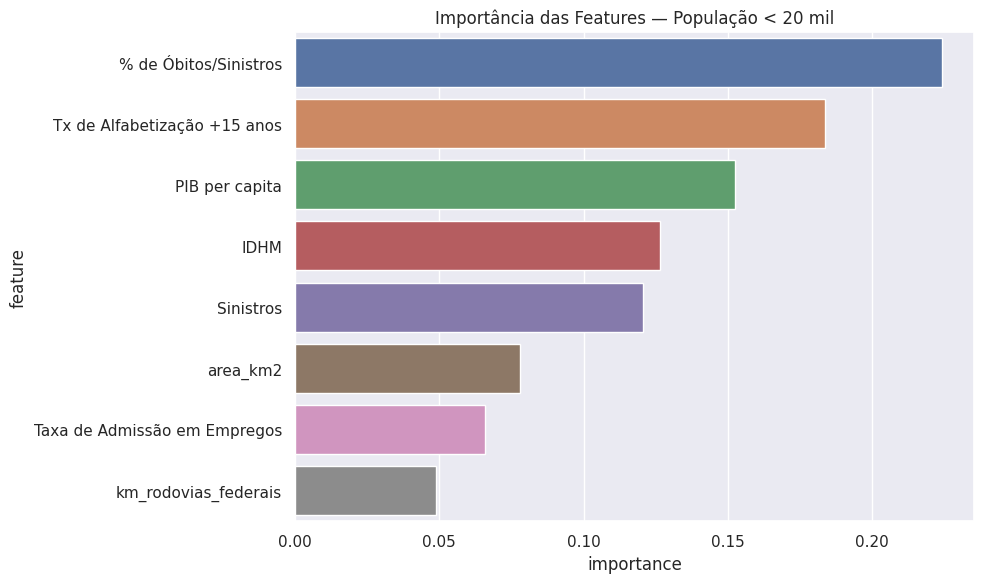

In [52]:
# Filtrar municípios
df_acima_100k = df[df['População'] < 20000]

# Preparação dos dados
X = df_acima_100k[features2]
y = df_acima_100k['Integrado ao SNT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processamento
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Modelo
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Avaliação
y_pred = rf_model.predict(X_test_scaled)
print("\nRelatório de Classificação — População < 20 mil:")
print(classification_report(y_test, y_pred))

# Importância das features
feature_importance = pd.DataFrame({
    'feature': features2,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features — População < 20 mil')
plt.tight_layout()
plt.show()

# 12. Anállise 


In [ ]:
# Função de classificação
def classificar_pib_per_capita(valor):
    if valor >= 15_000:
        return "Desenvolvimento médio-baixo"
    else:
        return "Muito baixo desenvolvimento"

# Aplicar classificação no DataFrame
df['Faixa PIB per capita'] = df['PIB per capita'].apply(classificar_pib_per_capita)

# Função de classificação
def classificar_pib_per_capita(valor):
    if valor >= 100_000:
        return "Altíssimo desenvolvimento"
    elif valor >= 60_000:
        return "Alto desenvolvimento"
    elif valor >= 15_000:
        return "Desenvolvimento Baixo-intermediário"
    else:
        return "Muito baixo desenvolvimento"



🔸 Relatório — Desenvolvimento médio-baixo:
              precision    recall  f1-score   support

         Não       0.68      0.84      0.75        92
         Sim       0.89      0.78      0.83       161

    accuracy                           0.80       253
   macro avg       0.79      0.81      0.79       253
weighted avg       0.82      0.80      0.80       253



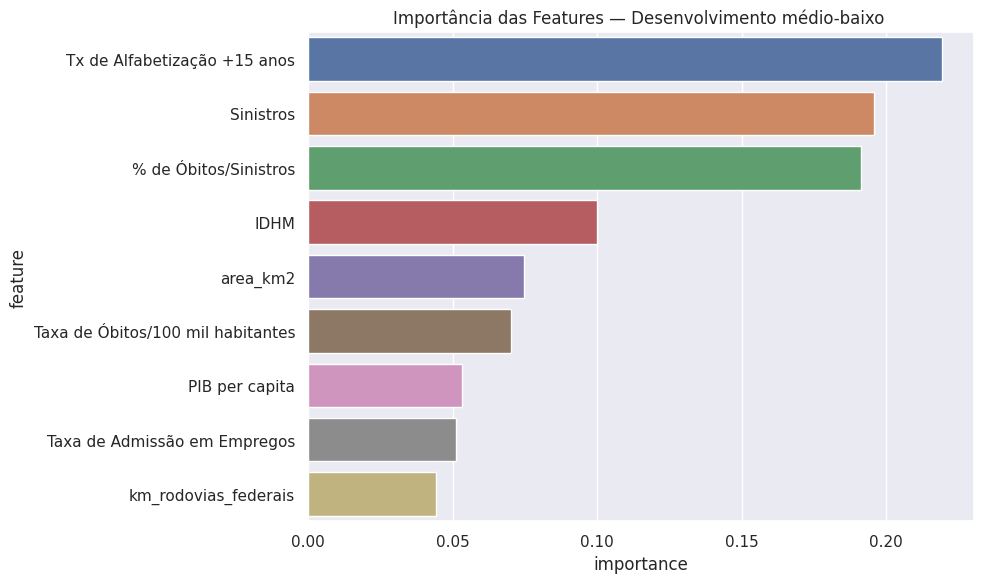

In [64]:
# Filtro: Desenvolvimento médio-baixo 
df_medio_baixo = df[(df['PIB per capita'] >= 15000) & (df['PIB per capita'] < 60000)]


# Separação de features e target
X = df_medio_baixo[features]
y = df_medio_baixo['Integrado ao SNT']

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processamento
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Modelo
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Avaliação
y_pred = rf_model.predict(X_test_scaled)
print("\n🔸 Relatório — Desenvolvimento médio-baixo:")
print(classification_report(y_test, y_pred))

# Importância das features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features — Desenvolvimento médio-baixo ')
plt.tight_layout()
plt.show()


🔸 Relatório — Muito baixo desenvolvimento:
              precision    recall  f1-score   support

         Não       0.91      0.91      0.91       626
         Sim       0.72      0.72      0.72       208

    accuracy                           0.86       834
   macro avg       0.81      0.81      0.81       834
weighted avg       0.86      0.86      0.86       834



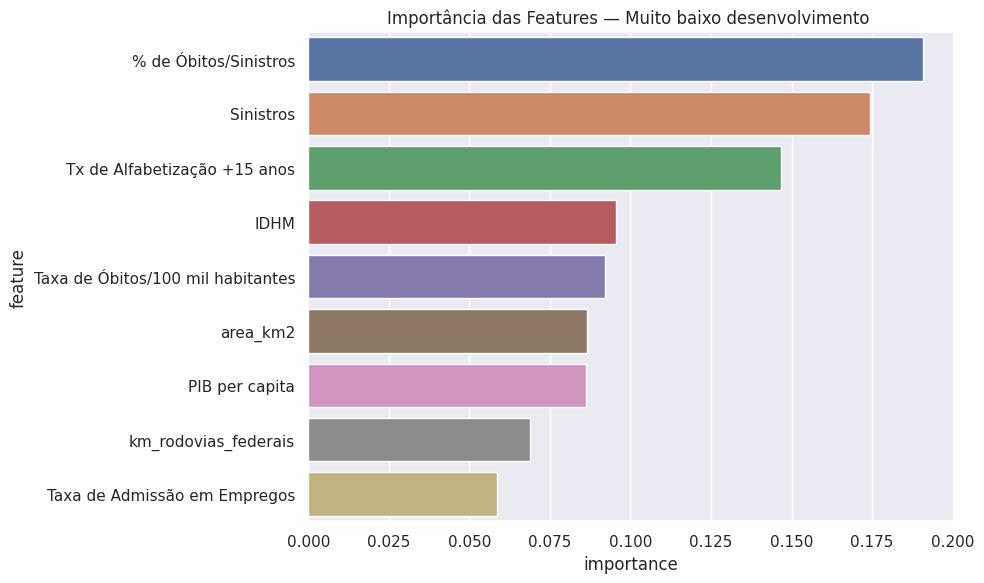

In [65]:
# Filtro: Desenvolvimento Muito baixo desenvolvimento 
df_muito_baixo_desenvolvimento = df[df['PIB per capita'] < 15000]


# Separação de features e target
X = df_muito_baixo_desenvolvimento[features]
y = df_muito_baixo_desenvolvimento['Integrado ao SNT']

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processamento
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Modelo
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Avaliação
y_pred = rf_model.predict(X_test_scaled)
print("\n🔸 Relatório — Muito baixo desenvolvimento:")
print(classification_report(y_test, y_pred))

# Importância das features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features — Muito baixo desenvolvimento ')
plt.tight_layout()
plt.show()